<a href="https://colab.research.google.com/github/gharashim/RL/blob/main/9_%EC%A0%95%EC%B1%85%EA%B2%BD%EC%82%AC%EB%B2%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym


class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)    # 입력 차원 명시
        self.fc2 = nn.Linear(128, action_size)  # 출력 차원 명시

    def forward(self, x):
        x = F.relu(self.fc1(x))
        probs = F.softmax(self.fc2(x), dim=1)   # dim=1 명시
        return probs



class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0002
        self.state_dim = 4
        self.action_size = 2
        self.memory = []  # (log_prob, reward) 저장

        self.pi = PolicyNetwork(self.state_dim, self.action_size)
        self.optimizer = optim.Adam(self.pi.parameters(), lr = self.lr)

    def get_action(self, state):
        # state = state[np.newaxis, :]
        # probs = self.pi(state)
        # probs = probs[0]
        # action = np.random.choice(len(probs), p = probs.data)
        # return action, probs[action]

        state = torch.FloatTensor(state).unsqueeze(0)  # (1, state_dim) 모양의 Tensor
        probs = self.pi(state)                         # softmax 확률 출력
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)       # 정수 action, 로그확률 반환


    def add(self, reward, prob):
        data = (reward, prob)
        self.memory.append(data)

    def update(self):
        self.optimizer.zero_grad()
        G = 0
        losses = []

        for log_prob, reward in reversed(self.memory):
            G = reward + self.gamma * G
            losses.append(-log_prob * G)

        loss = torch.stack(losses).sum()
        loss.backward()
        self.optimizer.step()
        self.memory = []

    # def update(self):
    #     self.optimizer.zero_grad()

    #     G = 0
    #     # loss = 0
    #     losses = []

    #     # G 계산
    #     for reward, _ in reversed(self.memory):
    #         G = reward + self.gamma * G

    #     # 손실 함수 계산
    #     # for _, prob in self.memory:
    #         # loss += -F.log(prob) * G
    #     for log_prob, _ in self.memory:
    #         loss += -log_prob * G

    #     loss.backward()
    #     self.optimizer.step()
    #     self.memory = [] # 메모리 초기화

In [ ]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
state = env.reset()[0]
agent = Agent()

action, prob = agent.get_action(state)
print(action, prob)

1 tensor([-0.7244], grad_fn=<SqueezeBackward1>)


In [ ]:
episodes = 3000
env = gym.make('CartPole-v1', render_mode="rgb_array")
agent = Agent()
reward_history = []

for episode in range(episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0

    while not done:
        action, prob = agent.get_action(state) # 행동 선택
        # 행동 수행
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        agent.add(reward, prob) # 보상과 행동의 확률을 에이전트에 추가
        state = next_state # 상태 전이
        total_reward += reward # 보상 총합 계산

    agent.update() # 정책 갱신
    reward_history.append(total_reward)

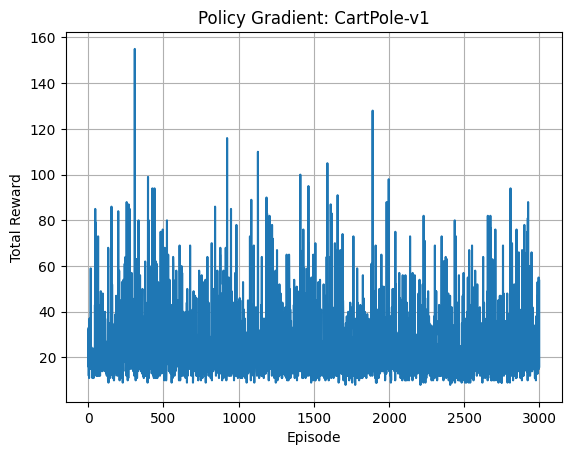

In [ ]:
import matplotlib.pyplot as plt

plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Policy Gradient: CartPole-v1')
plt.grid(True)
plt.show()
